In [1]:
import cv2
import numpy as np
import os
import pandas
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.imagenet_utils import _obtain_input_shape
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.utils import layer_utils
import keras.backend as K
import keras
import keras_resnet.models
%matplotlib inline



Using TensorFlow backend.


In [2]:
def read_images(filenames,directory,height,width):
    # Read Images into a Numpy array
    
    # Get the array size
    array_size = len(filenames)
    images = np.array([])
    #Preallocate the array.  This is much faster that numpy.append
    images = np.zeros((array_size,height,width,3))

    i=0
    for file in filenames:
        image = cv2.imread(directory + "/" + file,1)
        # Resize the image.
        resized_image = cv2.resize(image, (width,height))
        # Scale and add it to numpy array
        #print(image.shape,resized_image.shape)
        images[i] = resized_image
        i+=1

    
    
    return images

In [3]:
def get_labels(filelist,labels):
    
    labels.index = labels['Image']
    select_labels = np.array([])
    labels_filenames = []
    for file in filelist:
        select_labels = np.append(select_labels,labels.loc[file]['Encoded_Id'])
        labels_filenames.append(file)
    
    return select_labels,labels_filenames

In [4]:
def encode_labels(labels_df):

    labels = labels_df['Id'].values
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels_encode = le.transform(labels)
    
    labels_df['Encoded_Id'] = labels_encode 
    
    return labels_df

In [5]:
width = 128
height = 128

traindir="/home/james/Kaggle/Whale/Data/train"
labelsfile="/home/james/Kaggle/Whale/Data/train.csv"

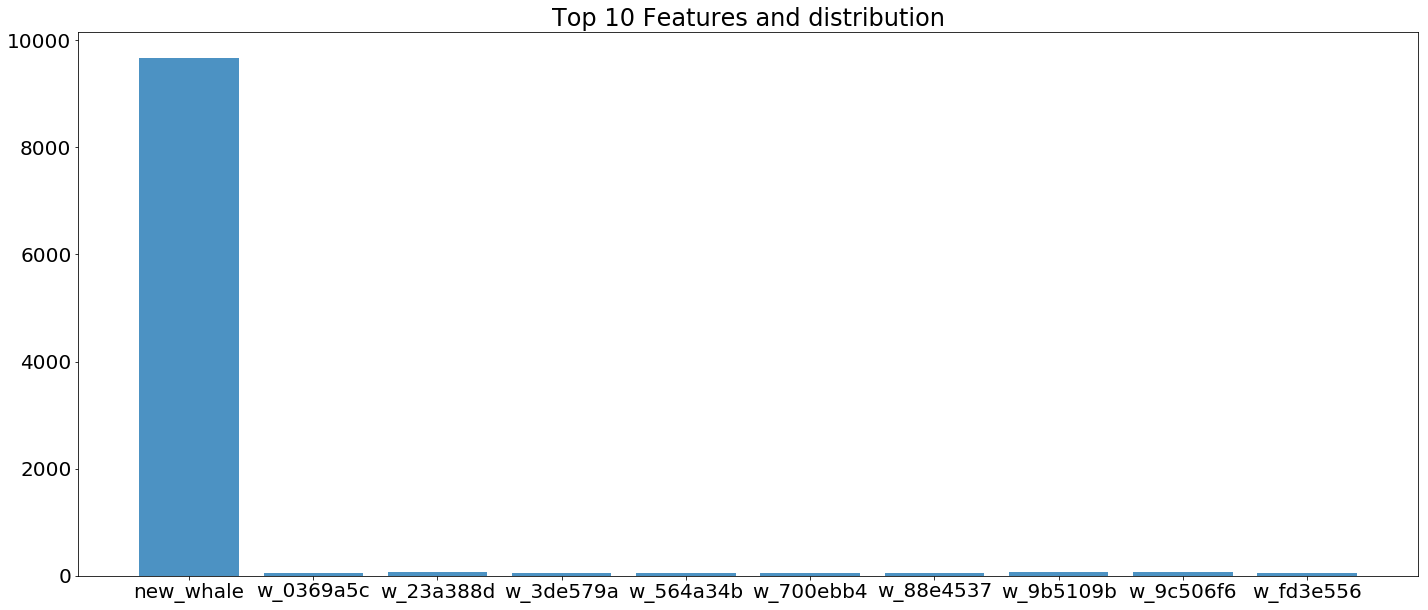

In [6]:
labels = pandas.read_csv(labelsfile)
labels.describe()
#with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(labels['Id'].value_counts())
    
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 24, 10 
pylab.rcParams["font.size"] = "20"

labels_count = labels['Id'].value_counts()
labels_count = labels_count[:10,]

plt.bar(labels_count.index, labels_count.values, alpha=0.8)
plt.title('Top 10 Features and distribution')
plt.show()



In [7]:
directory="masked_img"

filenames = os.listdir(traindir+"/" + directory)
filenames.sort()

# Remove new_whale
df = labels[labels.Id != 'new_whale']

labels_list = np.array([])
files_list = []
for index, row in df.iterrows():
    labels_list = np.append(labels_list,row['Id'])
    files_list.append(row['Image'])

print(labels_list.shape)
print(len(files_list))


(15697,)
15697


In [8]:
chunk_images = read_images(files_list,traindir + "/" + directory,height,width)
print(chunk_images.shape)




y=labels['Id']
values = labels_list

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(values),
                                                 values)

print(class_weights)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
train_labels = onehot_encoded

    


(15697, 128, 128, 3)
[3.13689049 3.13689049 0.31368905 ... 3.13689049 3.13689049 3.13689049]


In [9]:
input_shape = (height,width,3)

shape, classes = input_shape, 5004

from keras.applications import ResNet50

model = Sequential()
model.add(ResNet50(include_top=False,input_shape=shape,pooling='avg',weights=None))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 5004)              10253196  
Total params: 33,840,908
Trainable params: 33,787,788
Non-trainable params: 53,120
_________________________________________________________________


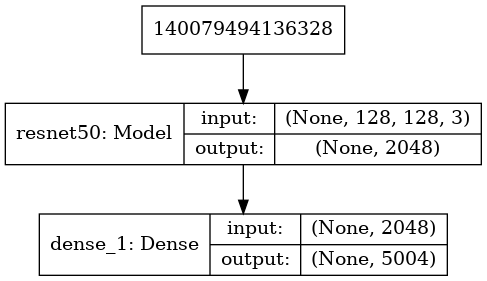

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='resnet50model.png')
from IPython.display import Image
Image(retina=True, filename='resnet50model.png')

In [11]:
#Save Models
filepath="/home/james/Kaggle/Whale/Data/whales-resnet" + ".best.hdf5"

checkpoint = ModelCheckpoint(filepath, 
                             monitor="acc",
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

callbacks_list = [checkpoint]

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    featurewise_center=True, 
    featurewise_std_normalization=True
    )

datagen.fit(chunk_images)

In [13]:
#model.load_weights(filepath)

history = model.fit_generator(
                    datagen.flow(chunk_images, train_labels, batch_size=80),
                    steps_per_epoch=len(chunk_images)/80, 
                    epochs=1500,
                    class_weight=class_weights,
                    callbacks=callbacks_list,
                    #initial_epoch=21
                    )

#history = model.fit(chunk_images,train_labels,
#                    #X_train, y_train,
#                    epochs=1500,
#                    callbacks=callbacks_list,
#                    class_weight=class_weights,
#                    #validation_data=(X_test,y_test),
#                    batch_size=100,
#                    verbose=1,
#                    shuffle=True)

Epoch 1/1500
197/196 [==============================] - 110s 560ms/step - loss: 8.8345 - acc: 0.0051

Epoch 00001: acc improved from -inf to 0.00491, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 2/1500
197/196 [==============================] - 100s 508ms/step - loss: 8.1379 - acc: 0.0068

Epoch 00002: acc improved from 0.00491 to 0.00682, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 3/1500
197/196 [==============================] - 105s 531ms/step - loss: 7.9600 - acc: 0.0082

Epoch 00003: acc improved from 0.00682 to 0.00828, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 4/1500
197/196 [==============================] - 108s 549ms/step - loss: 7.8278 - acc: 0.0072

Epoch 00004: acc did not improve from 0.00828
Epoch 5/1500
197/196 [==============================] - 113s 574ms/step - loss: 7.6958 - acc: 0.0089

Epoch 00005: acc improved from 0.00828 to 0.00892, saving model to /home/james/Kaggl

Epoch 38/1500
197/196 [==============================] - 111s 565ms/step - loss: 1.4427 - acc: 0.6214

Epoch 00038: acc improved from 0.59438 to 0.62133, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 39/1500
197/196 [==============================] - 112s 570ms/step - loss: 1.3385 - acc: 0.6494

Epoch 00039: acc improved from 0.62133 to 0.65057, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 40/1500
197/196 [==============================] - 112s 568ms/step - loss: 1.2629 - acc: 0.6702

Epoch 00040: acc improved from 0.65057 to 0.67121, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 41/1500
197/196 [==============================] - 114s 576ms/step - loss: 1.1958 - acc: 0.6825

Epoch 00041: acc improved from 0.67121 to 0.68408, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 42/1500
197/196 [==============================] - 112s 566ms/step - loss: 1.1399 - acc: 0.6984

E

197/196 [==============================] - 113s 574ms/step - loss: 0.2518 - acc: 0.9349

Epoch 00076: acc improved from 0.93521 to 0.93604, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 77/1500
197/196 [==============================] - 112s 569ms/step - loss: 0.2525 - acc: 0.9328

Epoch 00077: acc did not improve from 0.93604
Epoch 78/1500
197/196 [==============================] - 114s 577ms/step - loss: 0.2481 - acc: 0.9364

Epoch 00078: acc improved from 0.93604 to 0.93687, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 79/1500
197/196 [==============================] - 112s 570ms/step - loss: 0.2205 - acc: 0.9427

Epoch 00079: acc improved from 0.93687 to 0.94343, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 80/1500
197/196 [==============================] - 112s 570ms/step - loss: 0.2292 - acc: 0.9425

Epoch 00080: acc did not improve from 0.94343
Epoch 81/1500
197/196 [=====================

197/196 [==============================] - 114s 579ms/step - loss: 0.1121 - acc: 0.9684

Epoch 00174: acc did not improve from 0.98325
Epoch 175/1500
197/196 [==============================] - 114s 577ms/step - loss: 0.0956 - acc: 0.9749

Epoch 00175: acc did not improve from 0.98325
Epoch 176/1500
197/196 [==============================] - 114s 577ms/step - loss: 0.0765 - acc: 0.9802

Epoch 00176: acc did not improve from 0.98325
Epoch 177/1500
197/196 [==============================] - 115s 583ms/step - loss: 0.0739 - acc: 0.9810

Epoch 00177: acc did not improve from 0.98325
Epoch 178/1500
197/196 [==============================] - 114s 577ms/step - loss: 0.0678 - acc: 0.9847

Epoch 00178: acc improved from 0.98325 to 0.98490, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 179/1500
197/196 [==============================] - 112s 570ms/step - loss: 0.0629 - acc: 0.9858

Epoch 00179: acc improved from 0.98490 to 0.98573, saving model to /home/james/Kaggle/

197/196 [==============================] - 114s 577ms/step - loss: 0.0704 - acc: 0.9824

Epoch 00227: acc did not improve from 0.98828
Epoch 228/1500
197/196 [==============================] - 114s 577ms/step - loss: 0.0535 - acc: 0.9872

Epoch 00228: acc did not improve from 0.98828
Epoch 229/1500
197/196 [==============================] - 114s 578ms/step - loss: 0.0508 - acc: 0.9885

Epoch 00229: acc improved from 0.98828 to 0.98847, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 230/1500
197/196 [==============================] - 112s 571ms/step - loss: 0.0496 - acc: 0.9886

Epoch 00230: acc improved from 0.98847 to 0.98853, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 231/1500
197/196 [==============================] - 112s 567ms/step - loss: 0.0494 - acc: 0.9883

Epoch 00231: acc did not improve from 0.98853
Epoch 232/1500
197/196 [==============================] - 113s 576ms/step - loss: 0.0553 - acc: 0.9860

Epoch 00232

Epoch 279/1500
197/196 [==============================] - 112s 570ms/step - loss: 0.0389 - acc: 0.9914

Epoch 00279: acc did not improve from 0.99216
Epoch 280/1500
197/196 [==============================] - 114s 576ms/step - loss: 0.0367 - acc: 0.9930

Epoch 00280: acc improved from 0.99216 to 0.99293, saving model to /home/james/Kaggle/Whale/Data/whales-resnet.best.hdf5
Epoch 281/1500
197/196 [==============================] - 112s 570ms/step - loss: 0.0337 - acc: 0.9924

Epoch 00281: acc did not improve from 0.99293
Epoch 282/1500
197/196 [==============================] - 114s 579ms/step - loss: 0.0405 - acc: 0.9907

Epoch 00282: acc did not improve from 0.99293
Epoch 283/1500
197/196 [==============================] - 113s 575ms/step - loss: 0.0533 - acc: 0.9871

Epoch 00283: acc did not improve from 0.99293
Epoch 284/1500
197/196 [==============================] - 114s 577ms/step - loss: 0.0614 - acc: 0.9843

Epoch 00284: acc did not improve from 0.99293
Epoch 285/1500
197/196 [=

KeyboardInterrupt: 

In [15]:
testdir = "/home/james/Kaggle/Whale/Data/test/masked_img"
testfilenames = os.listdir(testdir)
testfilenames.sort()


test_images = read_images(testfilenames,testdir,height,width)
# Reshape Array
#test_images = test_images.reshape((test_images.shape[0],height,width,1))


In [16]:
model.load_weights(filepath)
# Make prediction
Predictions = model.predict(test_images)

In [17]:
test_csv = "/home/james/Kaggle/Whale/Data/test.csv"

test = testfilenames
col = ['Image']
test_df = pandas.DataFrame(test, columns=col)
test_df['Id'] = ''

for i, pred in enumerate(Predictions):
    ids = label_encoder.inverse_transform(pred.argsort()[-5:][::-1])
    ids = ids.tolist()
    sorted_idx = pred.argsort()[-5:][::-1]
    sorted_values = []
    for idx in sorted_idx:
        sorted_values.append(pred[idx])

    print(sorted_values)
    if sorted_values[0] < .60:
        ids.pop(-1)
        ids.insert(0,'new_whale')
    
    test_df.loc[i, 'Id'] = ' '.join(ids)

print(test_df.head(10))

test_df.to_csv(test_csv, index=False)

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999659, 3.4064135e-05, 2.0166973e-24, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.0415516e-30, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.8625541e-33, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.157379e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.2553316e-38, 0.0, 0.0, 0.0]
[1.0, 3.5717475e-32, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 3.8130058e-21, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.637516e-09, 0.0, 0.0, 0.0]
[1.0, 7.469045e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.3363498e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.794373e-34, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 1.2829964e-16, 0.0, 0.0, 0.0]
[1.0, 4.2786596e-08, 2.2032067e-36, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.999997, 2.925432e-06, 9.746858e-28, 6.529542e-36, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.0190934e-17, 1.1396187e-33, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.3513267e-09, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 8.7472565e-21, 0.0, 0.0, 0.0]
[0.9999865, 1.3477471e-05, 1.4516949e-38, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999999, 8.089788e-08, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9023195, 0.09768051, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.4300268e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999833, 1.6991166e-06, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.8726344e-12, 4.3467348e-38, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.3556266e-38, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.345676e-19, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.747001e-38, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.1303819e

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 1.0112096e-21, 5.3846388e-33, 0.0, 0.0]
[1.0, 5.292254e-23, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999726, 2.74266e-06, 6.9435614e-13, 3.4800715e-14, 3.292695e-27]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.6160336e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0315589e-29, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 8.802232e-33, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.237483e-24, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.811697e-17, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 8.7169414e-14, 1.2159187e-29, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.2403046e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.6498722e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.5074657e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 9.862309e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.2782876e-29, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999845, 1.5499194e-05, 1.8406707e-30, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.5610168e-26, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 9.29172e-27, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.003642e-10, 2.642338e-23, 1.0354136e-31, 8.775173e-34]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.3733755e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.4182106e-19, 3.778203e-26, 0.0, 0.0]
[1.0, 1.6942372e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.846841e-15, 5.497471e-38, 0.0, 0.0]
[1.0, 5.491883e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.7301384e-32, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999579, 4.2063253e-05, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.7468904e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.9407109e-30, 7.43145

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 8.433065e-15, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9998683, 0.00013168891, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.2525521e-25, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.1550082e-29, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.298257e-27, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.451342e-25, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.815315e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.326075e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.98975754, 0.010

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.5184291e-34, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.8294276e-09, 3.3041793e-27, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.6855953e-35, 0.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.111366e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.6090373e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 8.10251e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.5429983e-22, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 5.484151e-15, 0.0, 0.0, 0.0]
[0.9995466, 0.00045339053, 9.47987e-34, 1.1285291e-37, 4.997131e-38]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.323876e-10, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.4293516e-10, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.691526e-15, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.782721e-09, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 4.7607693e-23, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.6205374e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.1815794e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.1624581e-35, 9.906145e-38, 0.0, 0.0]
[1.0, 4.5620873e-15, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999963, 3.7505988e-06, 0.0, 0.0, 0.0]
[1.0, 2.666203e-38, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.538873e-24, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.380834e-14, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.602886e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.2592566e-16, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.460019e-38, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.2572407e-20, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 3.4764894e-34, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9999999, 6.248252e-08, 9.13105e-31, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.5417374e-11, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.7166506e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.4639755e-25, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.0506962e-12, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 7.831534e-16, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0590625e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 3.7618906e-28, 2.2302055e-37, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.5581919e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.3317183e-36, 4.074417e-38, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.1637675e-34, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99998116, 1.8787043e-05, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.3365659e-38, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999917, 8.7634095e-07, 6.6791417e-38, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.6977855e-10, 2.1758564e-33, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99992526, 7.4709315e-05, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.8181191e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.489404e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 2.841859e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0556009e-10, 8.626828e-37, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.6614226e-32, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.828598e-19, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.187286e-28, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.2580765e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 9.83921e-18, 4.924829e-34, 0.0, 0.0]
[1.0, 7.351556e-21, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.5340888e-15, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[0.9926104, 0.0073895706, 6.2716915e-24, 0.0, 0.0]
[1.0, 3.5785356e-34, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.0721396e-20, 0.0, 0.0, 0.0]
[1.0, 2.1512963e-24, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.8649487e-09, 1.8952174e-34, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.6559167e-16, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.430703e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.383031e-35, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.7909534e-23, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 4.0073895e-33, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.138702e-30, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.5128914e-37, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.713756e-32, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.374575e-21, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0,

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 1.6695107e-24, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.9605039e-32, 4.0186006e-38, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 9.6936213e-32, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999976, 2.1355419e-07, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.132381e-23, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.99999976, 2.525515e-07, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 1.10912175e-16, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.481211e-31, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.5677563, 0.3393203, 0.08740568, 0.0033901725, 0.00075837976]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.1345291e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.9192725e-23, 3.5505933e-26, 2.9795746e-32, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.907832e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.9522794e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.7496667e-22, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[0.75730115, 0.2426989, 8.015298e-19, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 6.3557738e-18, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.911011e-08, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 8.5119954e-36, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.8055128e-26, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.

/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/Anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.1237243e-28, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.845096e-38, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 3.9512624e-22, 5.879236e-38, 0.0, 0.0]
[0.80786836, 0.19213165, 0.0, 0.0, 0.0]
[0.83828294, 0.161717, 0.0, 0.0, 0.0]
[1.0, 4.1384702e-30, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 5.46929e-25, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.

In [ ]:
# Reference
#https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py